In [1]:
from __future__ import division

import os
import numpy.ma as ma
import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlats 1p0'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20151108/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20151108/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = 'AnaK_1pa2'
all_side_files_red = 'DoubleSpec/20151108/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20151108/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20151108/red0093.fits') #use these to get targetid
#target[0].header
##################################################

# RED ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


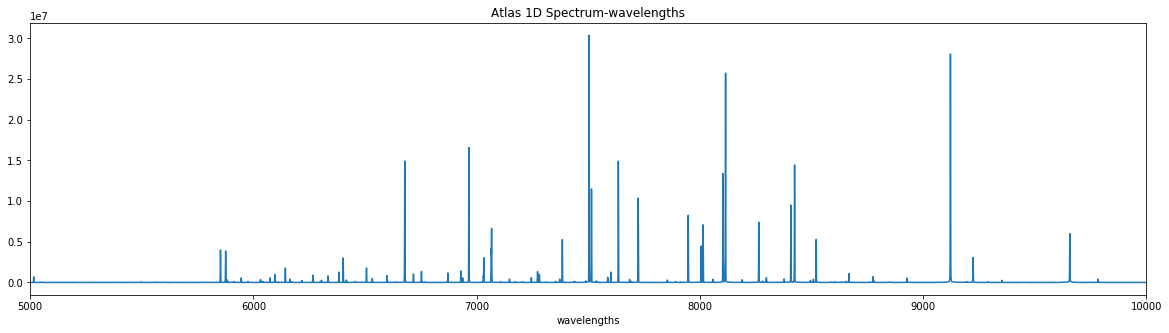

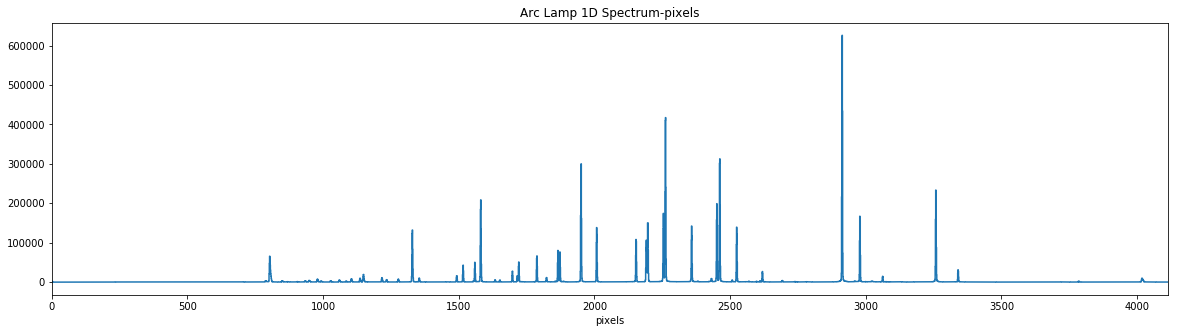

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


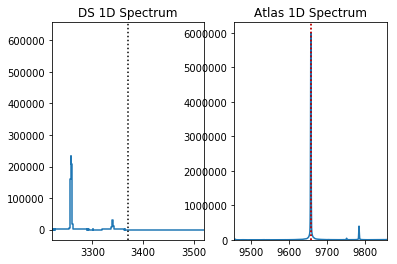

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3370,9657,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [2911,2260,1949,3256]
atlas_lines = [9122.9674,8115.311,7635.106,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Found line HeI at wl=7281.349
Clipped 0 lines
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.8887746861116286, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 2.33947154375024, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.8256156133032477, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.7561203378117187, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.6876625563580907, which is less than 10"
Failed to find line KrI at wl=7587.413: "Tried to find peak at 1919.53042918693 but it's in a valley, not a peak"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.04687394471

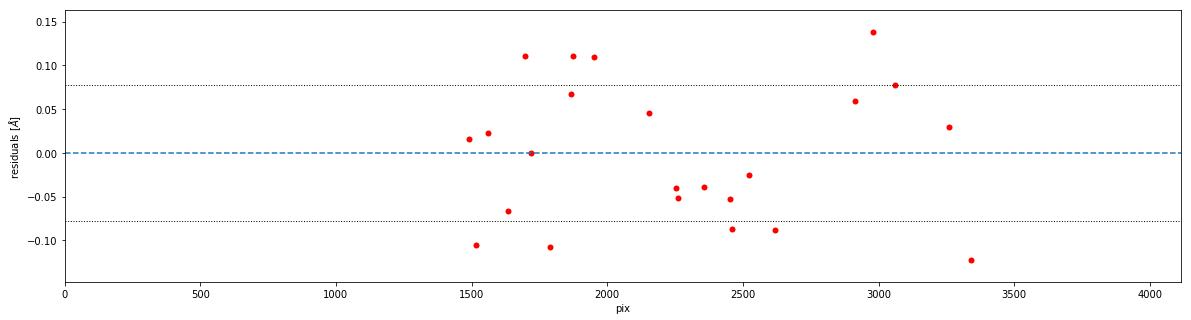

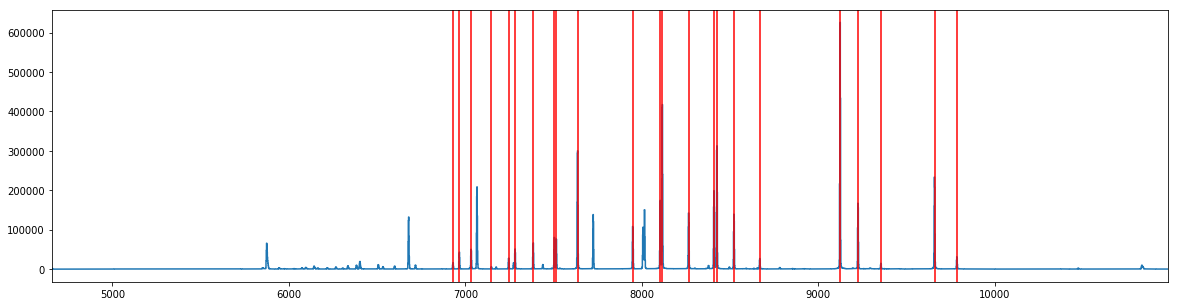

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

# Blue DS

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


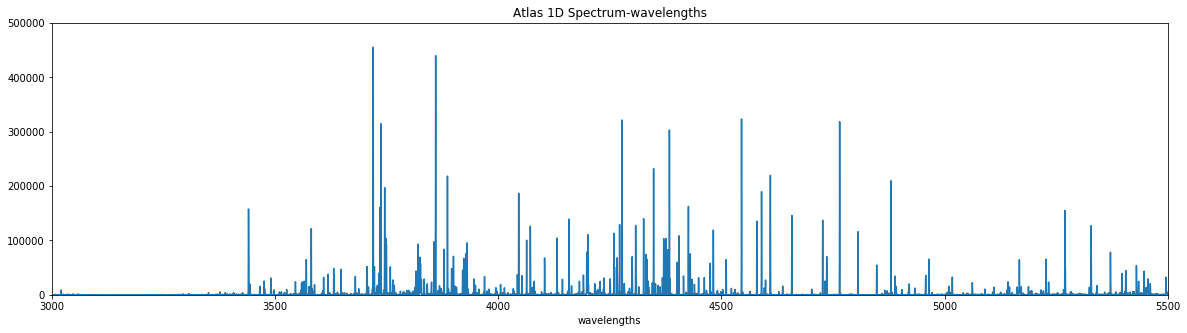

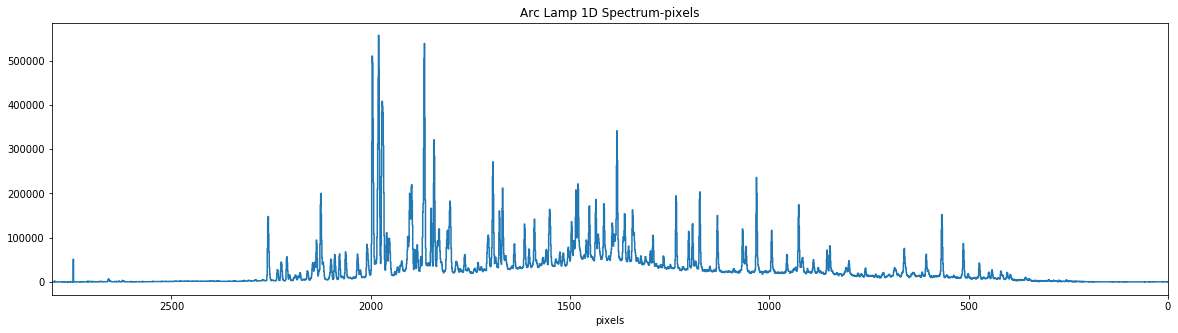

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


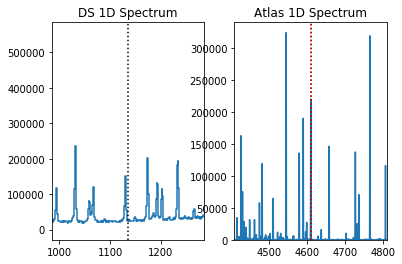

In [8]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [566,1031,2125,1995]
atlas_lines = [5269.5366,4764.8646,3581.1925,3719.9346]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 4.342313423417074, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 4.342313423417074, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 2.2865683295662476, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 4.1554542934611325, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.530395515752374, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.530395515752374, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.4249739084863702, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1708172486579012, which is 

Skipping line ArI at wl=6752.8335 - out of wl min/max
Skipping line ArI at wl=6766.6117 - out of wl min/max
Skipping line ArII at wl=6861.2688 - out of wl min/max
Skipping line ArI at wl=6871.2891 - out of wl min/max
Skipping line ArI at wl=6879.5824 - out of wl min/max
Skipping line ArI at wl=6888.1742 - out of wl min/max
Skipping line ArI at wl=6937.6642 - out of wl min/max
Skipping line ArI at wl=6951.4776 - out of wl min/max
Skipping line ArI at wl=6965.4307 - out of wl min/max
Skipping line ArI at wl=7030.2514 - out of wl min/max
Skipping line ArI at wl=7067.2181 - out of wl min/max
Skipping line ArI at wl=7107.4778 - out of wl min/max
Skipping line ArI at wl=7125.82 - out of wl min/max
Skipping line ArI at wl=7147.0416 - out of wl min/max
Skipping line ArI at wl=7158.8387 - out of wl min/max
Skipping line ArI at wl=7206.9804 - out of wl min/max
Skipping line ArI at wl=7265.1724 - out of wl min/max
Skipping line ArI at wl=7272.9359 - out of wl min/max
Skipping line ArI at wl=7311.

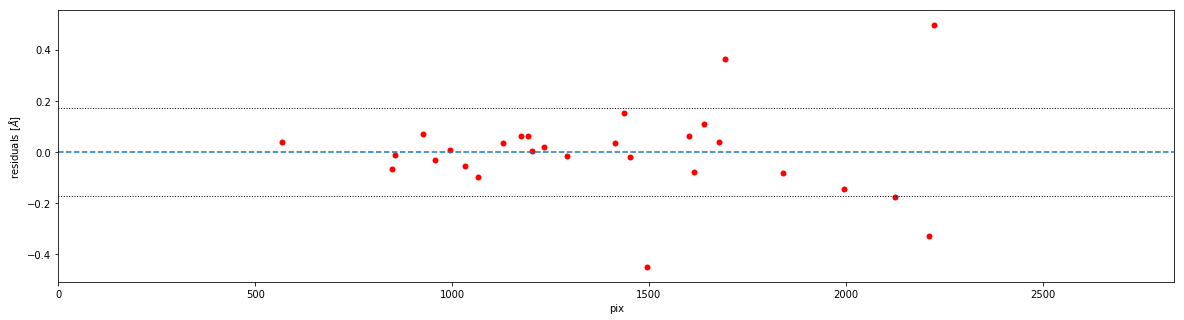

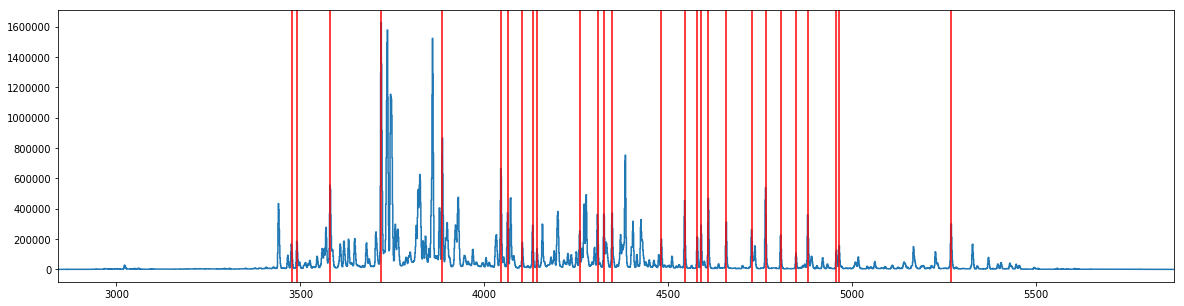

In [9]:
#creating a ds _ part three

ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

# Extracting 1D spectra (sky subtraction & stacking)


/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


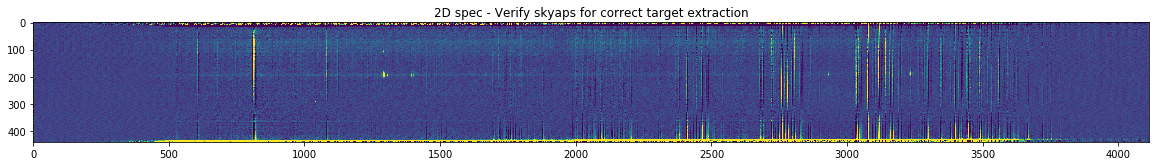

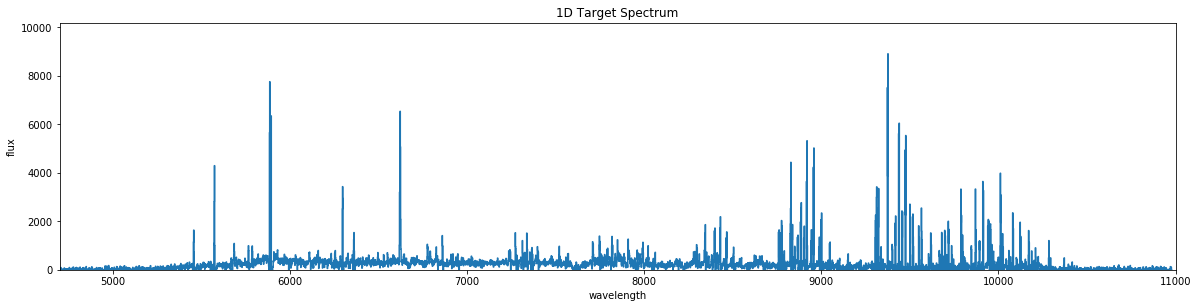

In [10]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red= [(20,30),(260,375)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (43,204)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??

#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for blueside
choose 1D target spec axis limits for blueside


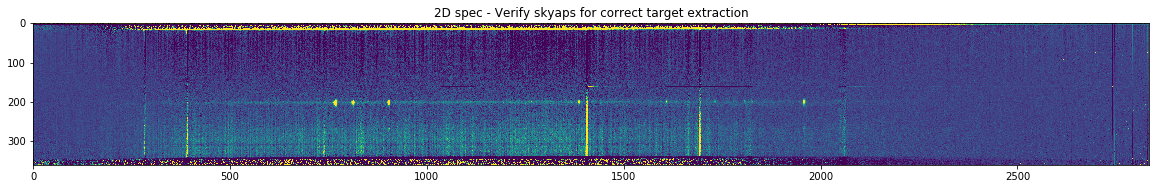

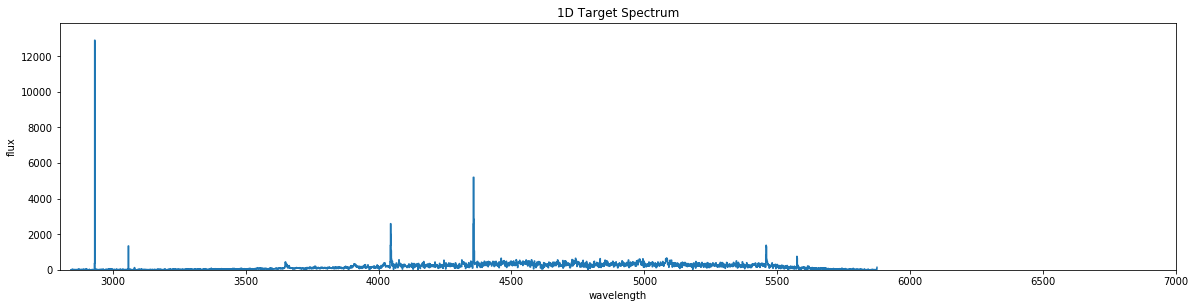

In [11]:
#BLUE side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(130,190),(295,350)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (271,306)#target spatial region
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

# Starting 2nd reduction technique for rot.curves


In [12]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red #avg(ok median) values from all images
best_emission_skyaps = skyaps_red #best sky aps
best_emission_model = model_red #best sky tilt estimation
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

# finding emission line centroids

In [13]:
#trying to understand where spec cut is in below cell

subimg2.data[0].shape

(4114,)

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (216, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


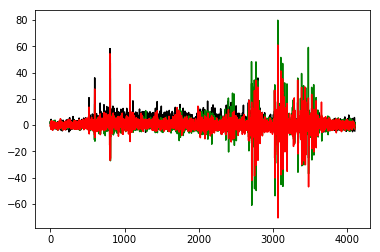

In [14]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(35,250) #target location 35,210 originally 43,204 in 1dspec,live values are a test
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[170],color='g')#near opposite galaxy edge
plt.plot(flux_data[105],color='r')#near galaxy center


#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

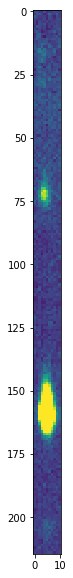

In [15]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################


testingthis=subimg2.data[35:250,1288:1299] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1288,1299) #(1289, 1297)
bestline_range_correction = (1278,1289)#(1279,1287) #includes shortened wl range
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

NameError: name 'flux_data_short' is not defined

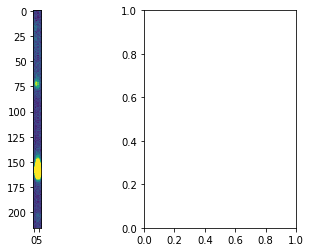

In [16]:
#my tests


#for reference
#flux_data_short = flux_data[:,1279:1287] #use 'bestline_range_correction' range
comparingthis = flux_data[:,1279:1287] #same def of flux_data_short from centroiding cell
#plt.figure(figsize=(10,10))
#plt.imshow(comparingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.imshow(flux_data_short,vmin=vmin,vmax=vmax)

fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(comparingthis,vmin=vmin,vmax=vmax)
ax1.imshow(flux_data_short,vmin=vmin,vmax=vmax)
print('this shouldnt have changed in the spactial direction tho... they should both be flux_data_short, so whats going on?? Something in PART THREE aka the centroiding cell changes flux_dat_short')

In [17]:
# my tests

(subimg2.data[::][0])
np.shape(subimg2.data[::][0])
np.shape(flux_data),np.shape(flux_data_short),np.shape(subimg2.data)

NameError: name 'flux_data_short' is not defined

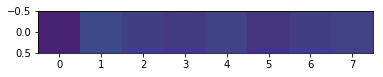

In [18]:
plt.imshow(flux_data[4:5,1279:1287],vmin=vmin,vmax=vmax)
print()

In [19]:
for count,row in enumerate(flux_data_short[0:1,::]):
    plt.plot(row)

NameError: name 'flux_data_short' is not defined

(1, 8)
centers 0.0 3.979462470184024
(1, 8)
centers 0.0 3.946276454086568
(1, 8)
centers 0.0 3.9518488845159614
(1, 8)
centers 0.0 3.890856538923512
(1, 8)
centers 0.0 3.8316467186168426
(1, 8)
centers 0.0 3.7800415116575974
(1, 8)
centers 0.0 3.700511521103332
(1, 8)
centers 0.0 3.76336587931514
(1, 8)
centers 0.0 3.7933567394974066
(1, 8)
centers 0.0 3.834863950778274
(1, 8)
centers 0.0 3.8772954104252726
(1, 8)
centers 0.0 3.903403818892714
(1, 8)
centers 0.0 3.9518084498596715
(1, 8)
centers 0.0 3.9714025894485094
(1, 8)
centers 0.0 3.972647767631858
(1, 8)
centers 0.0 4.023526079817306
(1, 8)
centers 0.0 4.065068121546666
(1, 8)
centers 0.0 3.94572687773845
(1, 8)
centers 0.0 4.290418510057115
(1, 8)
centers 0.0 3.944006663376002


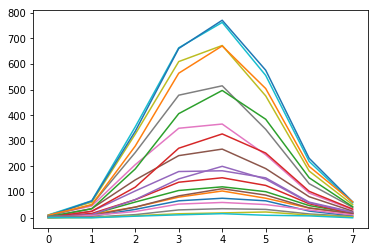

In [20]:
for row in flux_data[150:170,1279:1287]:#[4:10,1279:1287]: #4,6,9
#for row in flux_data[10:11,1279:1287]
    flux_fake2d2 = row[np.newaxis,:] #makes each row array into a fake2d
    print(np.shape(flux_fake2d2))
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)
    print('centers',centroid_xs,centroid_ys)
    #plt.scatter(centroid_xs,centroid_ys)
    #targetx = np.arange(len(row))
    #plt.plot(targetx,row)
    plt.plot(flux_fake2d2[0])
    #break
    
#still not sure how centroid space axis got reversed

badrow: 2 mean value: -3.2809189449736005 amplitude: 6.317774036382701
badrow: 3 mean value: -524.5948813286175 amplitude: 3.388252167201294
badrow: 7 mean value: -19.049403661841954 amplitude: 6.105787139846051


badrow: 91 mean value: -9.22046472286317 amplitude: 4.307262220183745
badrow: 99 mean value: -0.8983591642772074 amplitude: 4.468520206478317
badrow: 108 mean value: -2.961346764371113 amplitude: 4.732508738237758
badrow: 113 mean value: -2.523858746817845 amplitude: 2.069094447484485
badrow: 118 mean value: -8.638722429619435 amplitude: 4.34596767352944
badrow: 124 mean value: -5.233324793005037 amplitude: 3.5914212587600893
badrow: 131 mean value: -429.9684601747943 amplitude: 4.143052219777118
badrow: 138 mean value: -16.223233955558776 amplitude: 3.64515996648009
badrow: 174 mean value: -9.717820930729024 amplitude: 3.4235915901780842
badrow: 190 mean value: -9.563077981525833 amplitude: 3.382949813762412
badrow: 197 mean value: -1.823836229731829 amplitude: 2.6986758446512056
badrow: 209 mean value: -4.753219920026662 amplitude: 6.576958435472825
badrow: 212 mean value: -23.28859195095416 amplitude: 4.411992483632954


(1289, 1295)

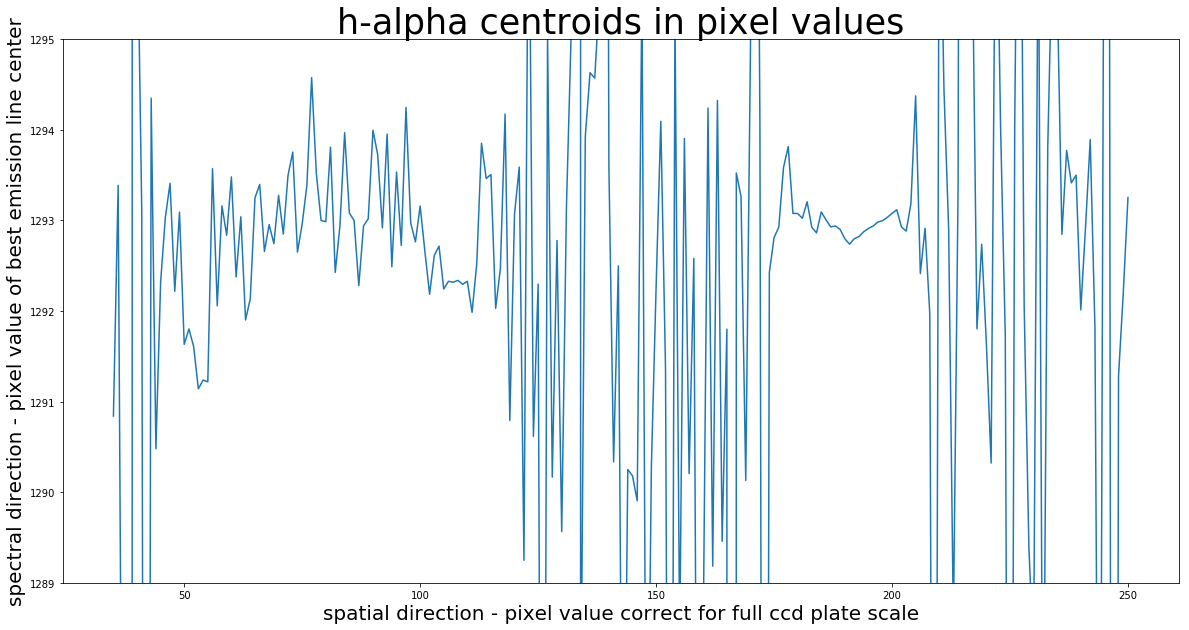

In [21]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0])))) #all rows, full ccd wl range
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1288:1299]#[1289:1297] #isolate wls around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1278:1289]#[:,1279:1287] #use 'bestline_range_correction' range

#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for count,row in enumerate(flux_data_short): 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys) #(space axis, so always zero)
    #print('why are these zero?',centroid_xs, centroid_ys) #x & y switched for some reason...
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = np.arange(len(row)) #ar(range(len(row)))
    y = row #flux values per wl in shortened target wl region, cycle goes thru each space row
    mean = centroid_xs
    #print('mean:',mean,'max:',max(y))
    if mean <=0.0:
        print('badrow:',count,'mean value:',mean, 'amplitude:',max(y))
     #   g_init = models.Gaussian1D(amplitude=max(y), mean=0, stddev=2.)
    #else:
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################
plt.ylim(1289,1295)

In [22]:
gaussian_means[4]

9.312411304577555

(-50, 50)

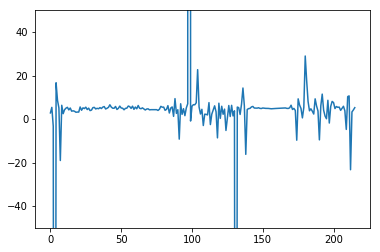

In [23]:


plt.plot(centroids_pix)
plt.ylim(-50,50)

In [24]:


# cs_pix=[]
# for i in centroids_pix:
#     print(i)
#     if i <=0.0:
#         c = np.nan
#     else:
#         c = i
#     cs_pix.append(c)
# #print(cs_pix) 
# cs_pix = np.array(cs_pix)
# masked_centroid_specpix_fullccd = cs_pix + wl_pix_correction + bestline_range_correction[0]
# #print(masked_centroid_specpix_fullccd)
# plt.figure(figsize=(20,10))
# plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
# plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
# plt.plot(target_spacepix_fullccd,masked_centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
# ###########################################################
# plt.title('h-alpha centroids in pixel values with mask',fontsize=35)
# ###########################################################
# #plt.ylim(1289,1295)

(1287, 1298)

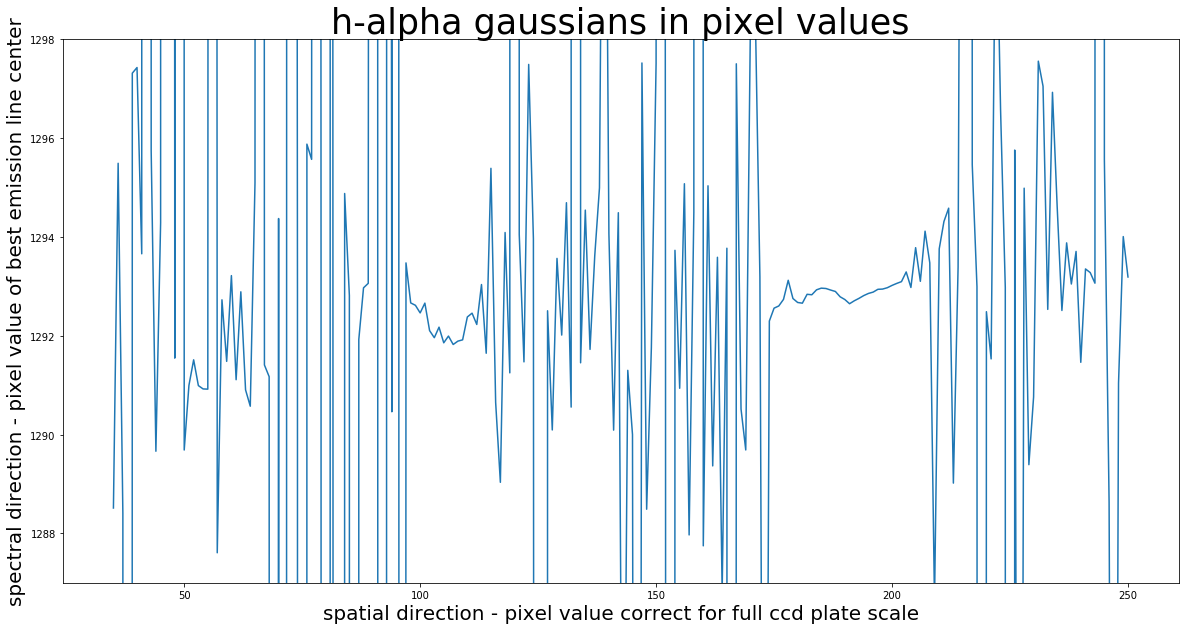

In [25]:
# plt.plot(centroids_pix)
# plt.ylim(-50,10)

plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)
plt.ylim(1287,1298)

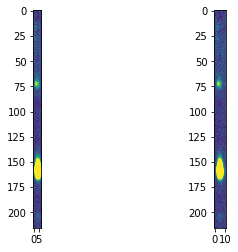

In [26]:
#my tests


#for reference
#flux_data_short = flux_data[:,1279:1287] #use 'bestline_range_correction' range
comparingthis = flux_data[:,1279:1287] #same def of flux_data_short from centroiding cell
#plt.figure(figsize=(10,10))
#plt.imshow(comparingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.imshow(flux_data_short,vmin=vmin,vmax=vmax)

fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(comparingthis,vmin=vmin,vmax=vmax)
ax1.imshow(flux_data_short,vmin=vmin,vmax=vmax)


In [27]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    #print()
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i, means_unc[i])
        badindices.append(i)
    else:
        ok = 'ok'
        #print(ok)
        #print(means_unc[i])
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 216 216
bad matrix at array: 3 None
bad matrix at array: 11 None
bad matrix at array: 12 None
bad matrix at array: 14 None
bad matrix at array: 21 None
bad matrix at array: 31 None
bad matrix at array: 34 None
bad matrix at array: 36 None
bad matrix at array: 37 None
bad matrix at array: 38 None
bad matrix at array: 40 None
bad matrix at array: 43 None
bad matrix at array: 45 None
bad matrix at array: 46 None
bad matrix at array: 47 None
bad matrix at array: 48 None
bad matrix at array: 55 None
bad matrix at array: 57 None
bad matrix at array: 58 None
bad matrix at array: 60 None
bad matrix at array: 61 None
bad matrix at array: 85 None
bad matrix at array: 90 None
bad matrix at array: 98 None
bad matrix at array: 104 None
bad matrix at array: 110 None
bad matrix at array: 111 None
bad matrix at array: 116 None
bad matrix at array: 125 None
bad matrix at array: 131 None
bad matrix at array: 184 None
number of bad fits is: 31


In [28]:
a = type(means_unc[2])#[1][1]
a

numpy.ndarray

In [29]:
#masking bad uncertaiinty values


evenmore_badindices=[]
masked_gsigs_means=[]
for i in  range(len(means_unc)):
    #print(type(means_unc[i]))
    #if type(means_unc[i][1][1]) != np.ndarray:
    if type(means_unc[i]) == np.ndarray: #'NoneType':
        gmatrix_unc=means_unc[i][1][1]
        #print(i)
    #b/c these are the good fits, keep those vals
    else:
        gmatrix_unc=np.nan
        evenmore_bad = i
        evenmore_badindices.append(evenmore_bad)
        #print(i)
    #print(i, gmatrix_unc)
    masked_gsigs_means.append(gmatrix_unc)
evenmore_badindices = np.array(evenmore_badindices)
masked_gsigs_means = np.array(masked_gsigs_means)
#print(masked_gsigs_means)
print(evenmore_badindices,len(evenmore_badindices),badindices) #good they match, as they should

[  3  11  12  14  21  31  34  36  37  38  40  43  45  46  47  48  55  57
  58  60  61  85  90  98 104 110 111 116 125 131 184] 31 [3, 11, 12, 14, 21, 31, 34, 36, 37, 38, 40, 43, 45, 46, 47, 48, 55, 57, 58, 60, 61, 85, 90, 98, 104, 110, 111, 116, 125, 131, 184]


In [30]:
#actually dont need this but it would have put two arrays in ascending order

def sortedMerge(a, b, res, n, m): 
    # Concatenate two arrays 
    i, j, k = 0, 0, 0
    while (i < n): 
        res[k] = a[i] 
        i += 1
        k += 1
    while (j < m): 
        res[k] = b[j] 
        j += 1
        k += 1
   
    # sorting the res array 
    res.sort() 

In [31]:
gaussian_means[4]

9.312411304577555

In [32]:
#masking bad gaussian values
more2_badindices=[]
more_badindices=[]
masked_gaussian_means=[]
for i in  range(len(gaussian_means)):
    #b/c bad fit produced no cov matrix
    if i in badindices:
        gaussian_means[i] = np.nan
        #print('sdjbine09g8boernh589430gt9fjoiwenvg50348jgv')
    #b/c mean value shouldnt be outside this pixel range
    elif gaussian_means[i] <=0.0:
        gaussian_means[i]=np.nan
        more2_bads = i
        more2_badindices.append(more2_bads)
    elif gaussian_means[i] >=8.0:
        gaussian_means[i] = np.nan
        more2_bads=i
        more2_badindices.append(more2_bads)
    #b/c these are the good fits, keep those vals
    else:
        gaussian_means[i]=gaussian_means[i]
    #print(i,gaussian_means[i])
    masked_gaussian_means.append(gaussian_means[i])
#more_badindices = np.array(more_badindices)
more2_badindices = np.array(more2_badindices)
masked_gaussian_means = np.array(masked_gaussian_means)


In [33]:

# changing those (evenmore bad indicies) values to nan in the uncertainity array


fullmask_sigma=[]
for i in  range(len(masked_gsigs_means)):
    #b/c bad fit produced no cov matrix
    if i in more2_badindices:
        masked_gsigs_means[i] = np.nan
    #b/c these are the good fits, keep those vals
    else:
        masked_gsigs_means[i]=masked_gsigs_means[i]
    #print(i,masked_gsigs_means[i])
    fullmask_sigma.append(masked_gsigs_means[i])
fullmask_sigma = np.array(fullmask_sigma)


In [34]:
print(more2_badindices)

[  4   5   7  22  51  56  88  91 108 112 115 118 122 124 129 132 135 136
 138 174 180 181 187 188 190 192 196 197 199 209 212]


In [35]:
for count,i in enumerate(masked_gaussian_means):
    print(count,i)

0 0.5133190976889696
1 7.4891262501724
2 0.40431669471562026
3 nan
4 nan
5 nan
6 5.657386038177121
7 nan
8 7.741090429564547
9 1.6620815016464772
10 6.284243255971659
11 nan
12 nan
13 3.5468346030937403
14 nan
15 1.6867808508750737
16 2.994082447657308
17 3.5121326778737774
18 2.9907380162245287
19 2.9230539250536878
20 2.9187376865241257
21 nan
22 nan
23 4.7265297913999875
24 3.4808796398581143
25 5.215980210231052
26 3.1097161995932314
27 4.888293438323859
28 2.9044609310210006
29 2.573366483365966
30 7.092849671943782
31 nan
32 3.4075158585075034
33 3.1713669759724326
34 nan
35 6.371235035075628
36 nan
37 nan
38 nan
39 4.892288928474711
40 nan
41 7.876491184996048
42 7.568538148815661
43 nan
44 5.109877514940537
45 nan
46 nan
47 nan
48 nan
49 6.877686921417065
50 4.812439896321182
51 nan
52 3.9237118295654683
53 4.968947617122621
54 5.05979510431621
55 nan
56 nan
57 nan
58 nan
59 2.460777778128573
60 nan
61 nan
62 5.472994153026653
63 4.663562244571926
64 4.614932456993995
65 4.4612

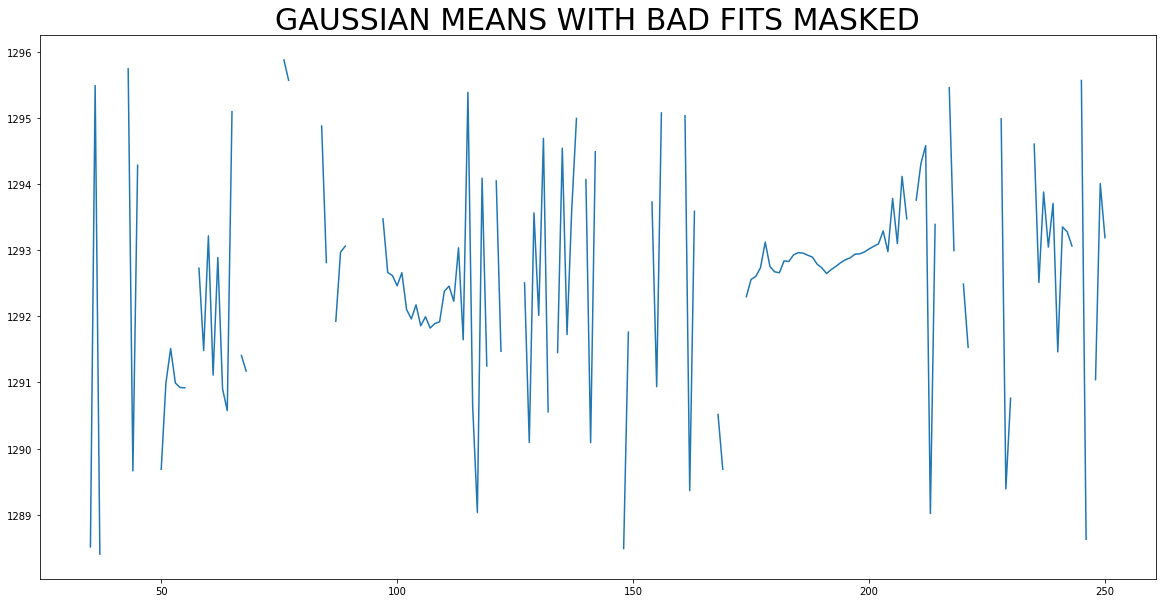

In [36]:
gaussmeans_specpix_fullccd_MASKED = masked_gaussian_means + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = masked_gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
#plt.ylim(1280,1300)
#plt.ylim(1289,1295)


(1288, 1297)

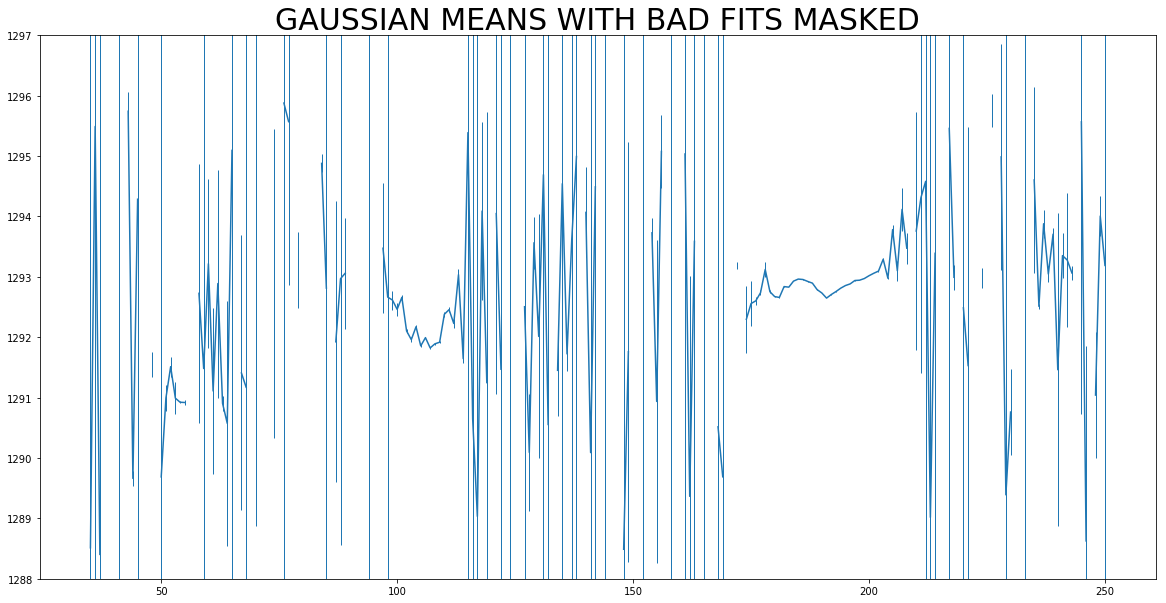

In [37]:
#with error bars


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1) #,alpha=0.5)
plt.ylim(1288,1297)

(1288, 1297)

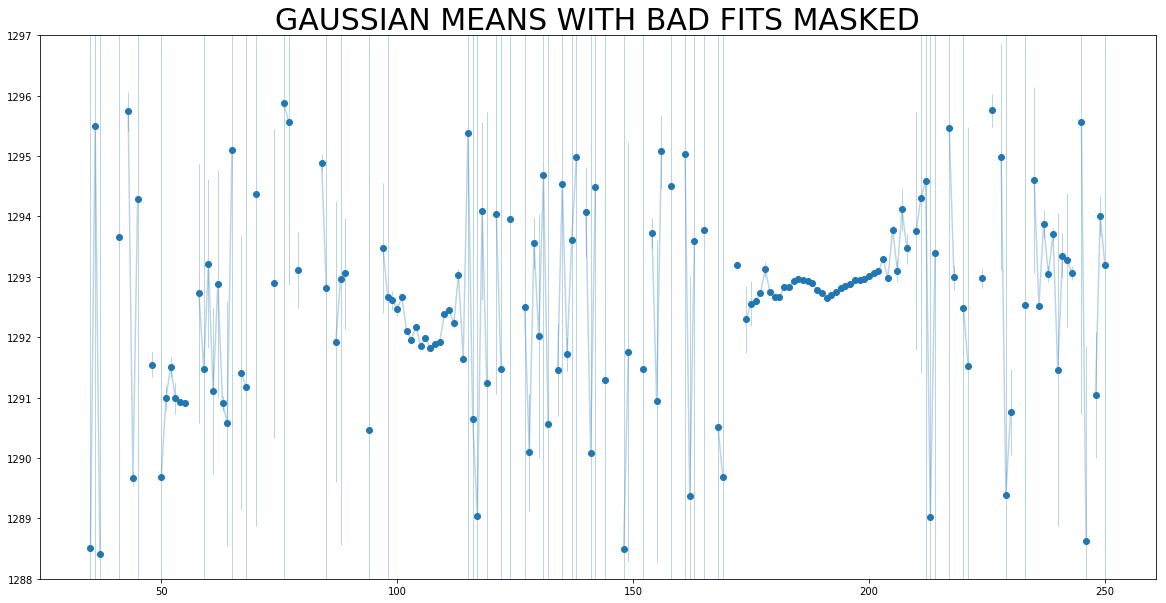

In [38]:
plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1,alpha=.3)
plt.ylim(1288,1297)

In [39]:
#creating  mask

# maskarray = np.zeros(len(gaussian_means))
# for i in badindices:
#     maskarray[i]=1
    
# maskarray.astype(np.int)
# maskarray

# x = gaussian_means
# mx = ma.masked_array(x, mask=maskarray)
# maskarray

In [40]:
# gaussmeans_specpix_fullccd_MASKED = mx + wl_pix_correction + bestline_range_correction[0]
# gaussmax_specpix_fullccd_MASKED = mx + stddev + wl_pix_correction + bestline_range_correction[0]



# plt.figure(figsize=(20,10))
# plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
# plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
# #plt.ylim(1280,1300)
# plt.ylim(1289,1295)


In [41]:
print(gaussmeans_specpix_fullccd_MASKED)

[1288.5133191  1295.48912625 1288.40431669           nan           nan
           nan 1293.65738604           nan 1295.74109043 1289.6620815
 1294.28424326           nan           nan 1291.5468346            nan
 1289.68678085 1290.99408245 1291.51213268 1290.99073802 1290.92305393
 1290.91873769           nan           nan 1292.72652979 1291.48087964
 1293.21598021 1291.1097162  1292.88829344 1290.90446093 1290.57336648
 1295.09284967           nan 1291.40751586 1291.17136698           nan
 1294.37123504           nan           nan           nan 1292.89228893
           nan 1295.87649118 1295.56853815           nan 1293.10987751
           nan           nan           nan           nan 1294.87768692
 1292.8124399            nan 1291.92371183 1292.96894762 1293.0597951
           nan           nan           nan           nan 1290.46077778
           nan           nan 1293.47299415 1292.66356224 1292.61493246
 1292.46123624 1292.65943738 1292.10307633 1291.95966466 1292.17278708
 1291.85

In [42]:
# plt.figure(figsize=(20,10))
# plt.title('Gaussian Means, including BAD fits')
# plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)
# plt.ylim(1280,1300)

(6616, 6628)

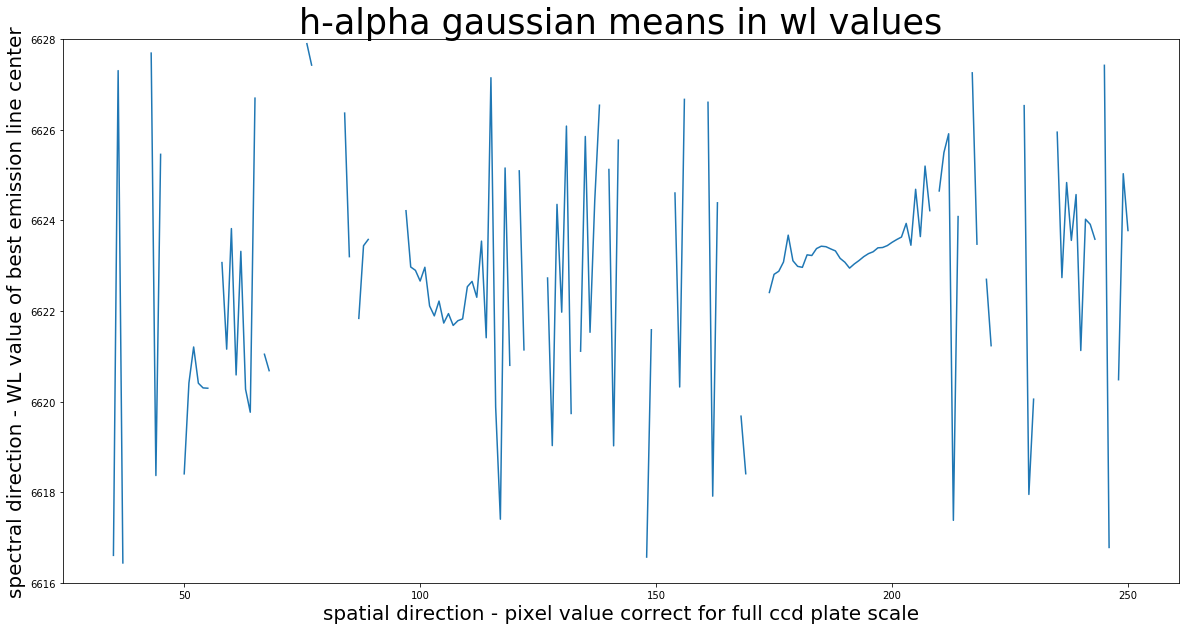

In [43]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
##########################################################
#plt.ylim(6620,6625)
#plt.ylim(6600,6655)
plt.ylim(6616,6628)

In [44]:
#old tests with prior mask
wl_gaussians[10:13] #same as above, (index=11), these all spit out same wl when should be mask
wl_gaussians[2:5] #middle value (index=3)should have been masked, why wasnt it?
#maybe try masking corrections, create array like zeros and sum along an axis instead of stright adding


array([6616.4384367,          nan,          nan])

# Getting Galaxy Spatial Core Pix Value



In [45]:
# plt.figure(figsize=(26,4))
# plt.imshow(flux_data,vmin=.02,vmax=50);
# #plt.xlim(1279,1288)
# plt.xlim(1229,1337)

In [46]:
# #USING SECTIONS SURROUNDING HALPHA WL RANGE
# np.shape(flux_data)#(226,4104) #note that this is missing those wl's


# #making arrays surrounding best emission line
# ################################################
# upperha = 1287
# lowerha = 1279
# #################################################
# width_sections = 50 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
# upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
# lower_one = upper_one - width_sections
# lower_two = upperha + 1 #giving it some distance
# upper_two = lower_two + width_sections
# first_section = flux_data[:,lower_one:upper_one]
# second_section = flux_data[:,lower_two:upper_two]
# print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


# #collapsing both sections in the spatial direction (histogram like)
# first_section_sum = np.sum(first_section,axis=1) 
# first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
# second_section_sum = np.sum(second_section,axis=1)
# second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
# print('shape of first section 2d:', np.shape(first_section2d))
# print('shape of second section 2d:', np.shape(second_section2d))


# #does the centroiding
# x_first, y_first = centroid_com(first_section2d)
# x_second, y_second = centroid_com(second_section2d)
# print('first section centroid x,y:',x_first,y_first)
# print('second section centroid x,y:',x_second,y_second)



# #verify by plots
# f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(first_section2d);
# ax2.plot(second_section2d);
# #note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
# ax1.plot(y_first,x_first, '.', markersize=10)
# ax2.plot(y_second,x_second, '.', markersize=10)


# #averaging the two core values, the y's
# core_array = np.array([y_first,y_second])
# core_avgcentroids = np.mean(core_array)
# print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

# #FULL CCD pixel value of core
# core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
# print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

# spectral core

In [47]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(masked_gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print('pix value of halpha core spectral axis is:',bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

pix value of halpha core spectral axis is: 1292.6022090561867
Best emission line "core" wl (based on gaussian fits) is: 6622.877854271412 Angstrom


In [48]:
wl_gauss_test = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
average = np.nanmean(wl_gauss_test)
#print(wl_gauss_test,'thank you next',wl_gaussians,'average of the averaged',average)



# Converting Pixels --> kpc 

In [49]:
# distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [50]:
#actual converting for loop CENTROIDS pixels to kpc
### good for core defined by 2 sections around halpha

# #converts pixels to kpc (distance profile)
# arcmins_sections =[]
# distances_sections=[]
# more_sections = []


# #converts pix to kpc and saves as quantity list
# for i in distance_pix_wrtcore_sections:
#     r_in_arcmin = 1*u.arcmin
#     redplatescale = 0.293*u.arcsec/u.pixel
#     blueplatescale = 0.389*u.arcsec/u.pixel
#     dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
#     dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
#     r_in_pixel = i*u.pixel
#     ################################################################
#     r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
#     distance = 34.8*u.Mpc # distance of object (host) from us
#     ###############################################################
#     rad_to_arcmin = (1*u.rad).to('arcmin')
#     r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
#     more_sections = r_in_kpc #/ (1*u.kpc)
#     distances_sections.append(more_sections.value)
# distances_sections = np.array(distances_sections)

In [51]:
### doesnt rely on distance from core



distances_sections_target=[]
more_sections_target = []

#converts pix to kpc and saves as quantity list
for i in target_spacepix_fullccd:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 34.8*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections_target = r_in_kpc #/ (1*u.kpc)
    distances_sections_target.append(more_sections_target.value)
distances_sections_target = np.array(distances_sections_target)

In [52]:
#GAUSSIAN MEANS plot with pix-wls & kpc

# plt.figure(figsize=(25,10))
# plt.title('Best emission line Gaussian means', SIZE=25)
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('spectral direction in pixels',fontsize=20)
# plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd_MASKED)

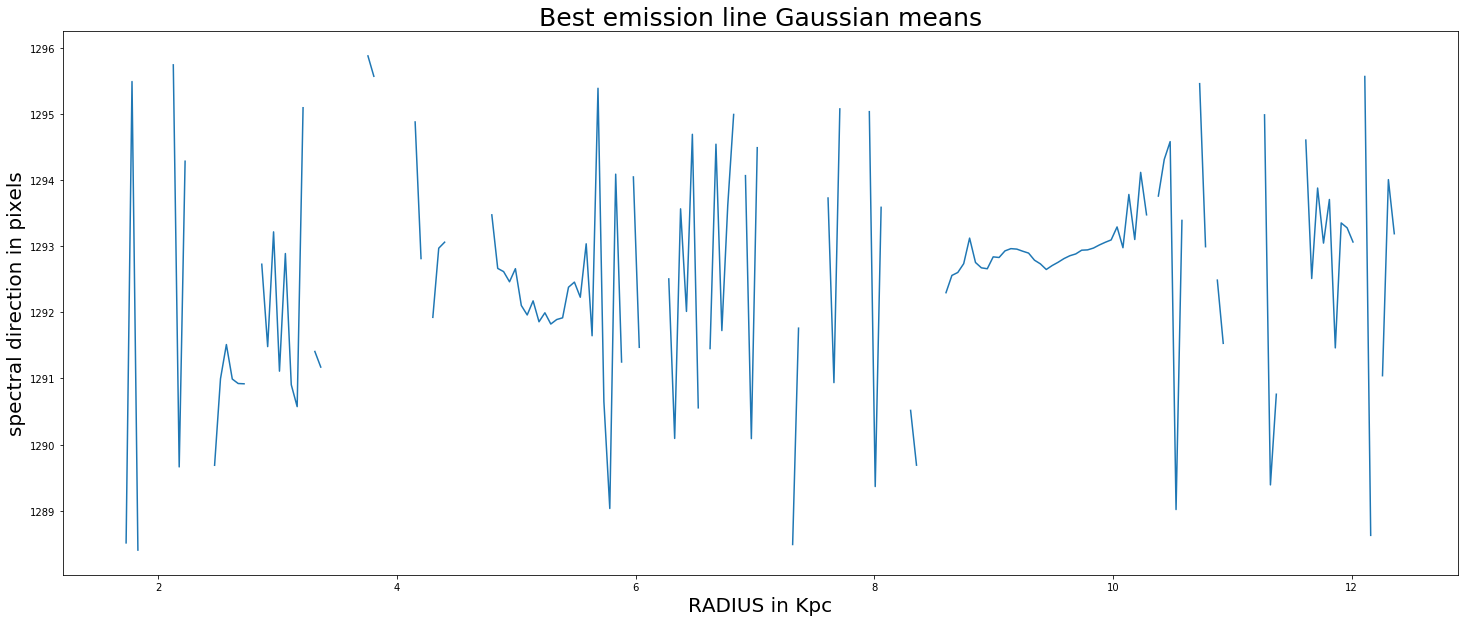

In [53]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections_target * u.kpc, gaussmeans_specpix_fullccd_MASKED)

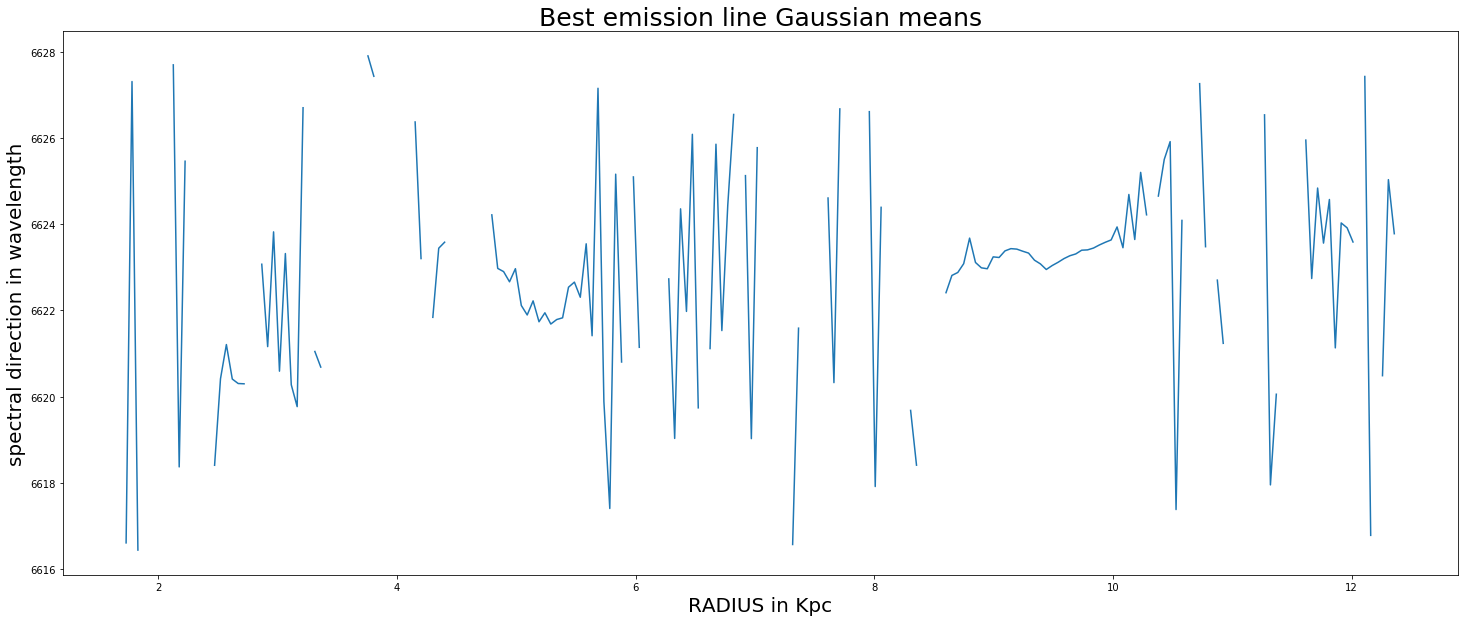

In [54]:
plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections_target * u.kpc, wl_gaussians)

# Converting pix ----> wl ----> velocity

In [55]:
#convert pix to wl via ds
###################################################################
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd_MASKED)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
#core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [56]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
#v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
#v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
v_core = ((average/(6563*u.angstrom)) -1) * const.c #core velocity


###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
#y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core.to('km/s'))

velocity of best emission line's spectral 'core': 2735.172219721947 km / s


In [57]:
#used core from sections

# plt.figure(figsize=(25,10))
# #######################################################
# plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
# #######################################################
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('VELOCITY in km/s',fontsize=20)
# plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
# plt.ylim(-250,250) #adjust as needed to center around zero
# plt.plot(0,0,'.', markersize=25)

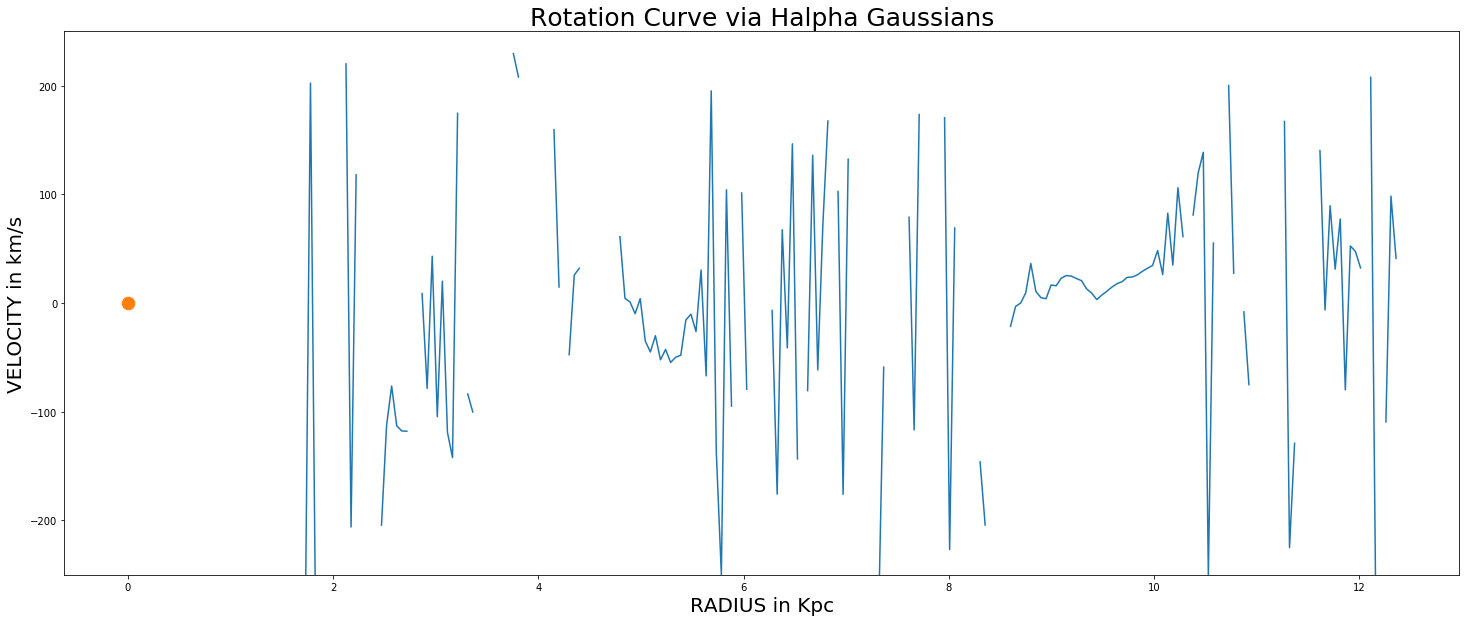

In [58]:
#no core yet -use when letting model decide

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections_target * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

# error bars

In [59]:
#previous way using core from sections

#using output from GAUSSIAN fit to determine error; tbd how to for CENTROIDS

#method to obtain sigma = subttract velocities of (mean+sigma) - mean = sigma 
# ###########################################sub uncs for means_unc if used matrix fix
# sigma_gauss_pix = np.sqrt(np.abs(means_unc)) #taking sqrt of unc to get a true sigma
# ################################################
# #correct to full ccd pix scale
# #print(sigma_gauss_pix)
# means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
# #apply ds
# means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


# #making into velocities
# v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
# #in converting pix2wl2vel section...already did same steps for means w/o sigma


# #extracting sigma velocity
# v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
# #print(np.shape(v_unc))
# #np.reshape(v_unc,(226,))
# print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocity

In [60]:
#newer way trying to get core from eriks model

########################################### fullmask_sigma is in pixels
sigma_gauss_pix = np.sqrt(np.abs(fullmask_sigma)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocitys_unc

v_unc (216,)


(-250, 250)

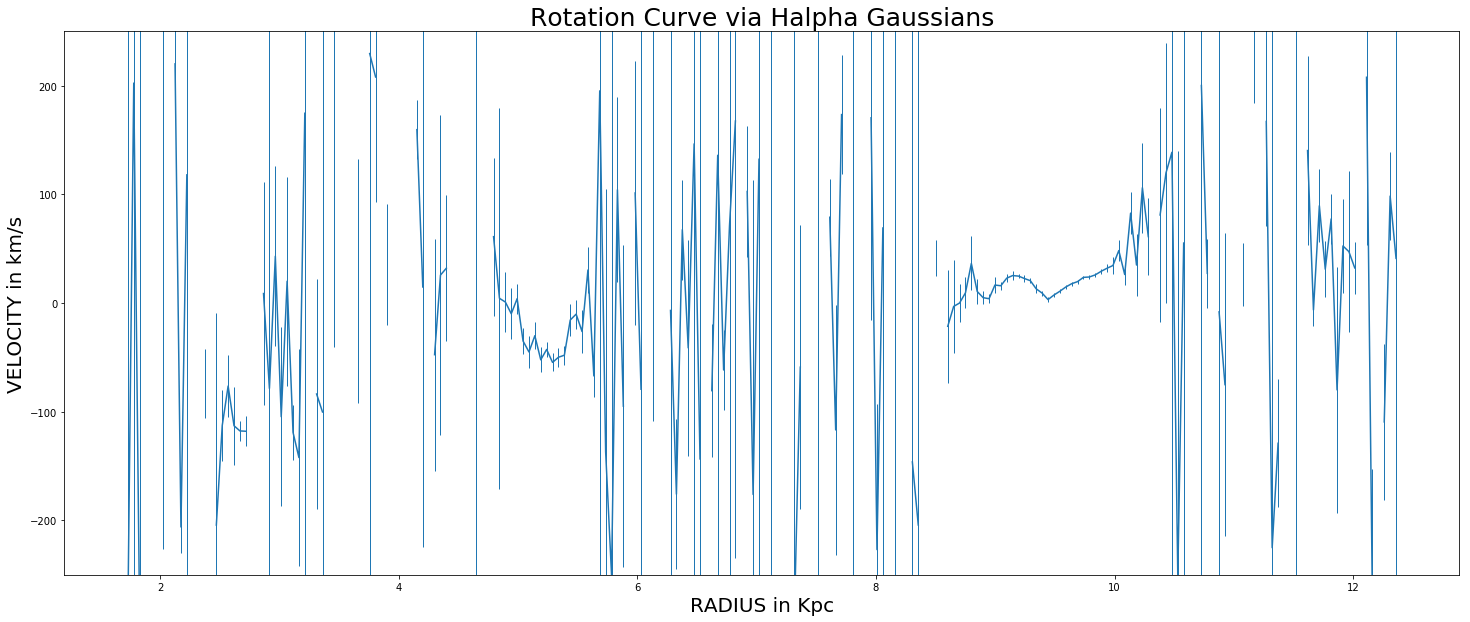

In [61]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(distances_sections_target * u.kpc, y_axis_Gvelocity,yerr=v_unc,elinewidth=1)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

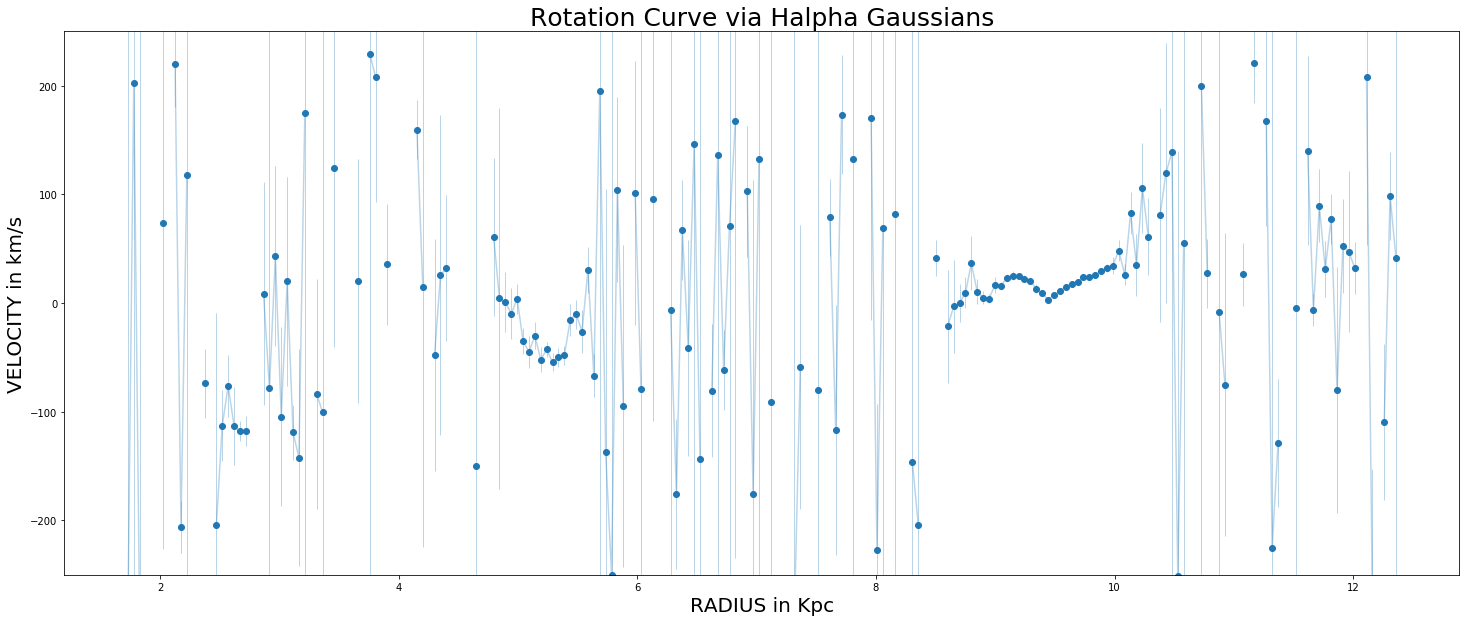

In [62]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections_target * u.kpc, y_axis_Gvelocity)
plt.errorbar(distances_sections_target * u.kpc, y_axis_Gvelocity,yerr=v_unc,elinewidth=1,alpha=0.3)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

In [63]:
arr = np.asarray

# Mass Modeling

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta sigma omega
    ----- ----- ----- ----- -----
      6.0   2.5 0.001  80.0   0.3


(-200, 200)

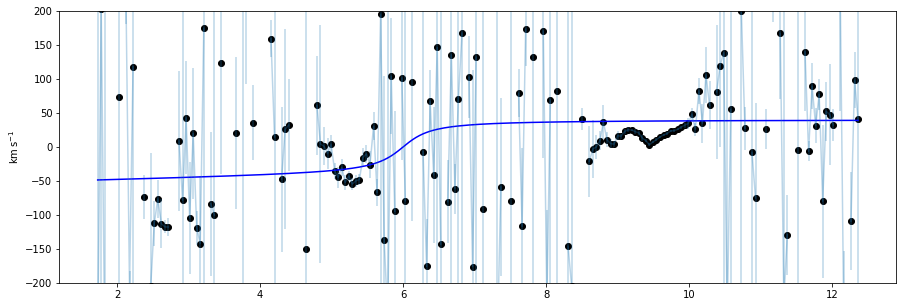

In [84]:
#lets the model find the spatial core

@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=2.5, beta=.001, sigma=80, omega=.3):
    dr = r - r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)

m_init = eriksmodel(bounds={'r_cen': (6,8)})
##m_init.bounds = {'r_cen':(1,3)}
#m_init.r_cen.bounds = (1,3)
#m_init.prameters['r_cen'].bounds = (1,3)
fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target, y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections_target,y_axis_Gvelocity,yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good

# old attempts below

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    alpha  beta sigma omega
    ----- ----- ----- -----
    0.001 0.001 250.0   0.4


(-500, 500)

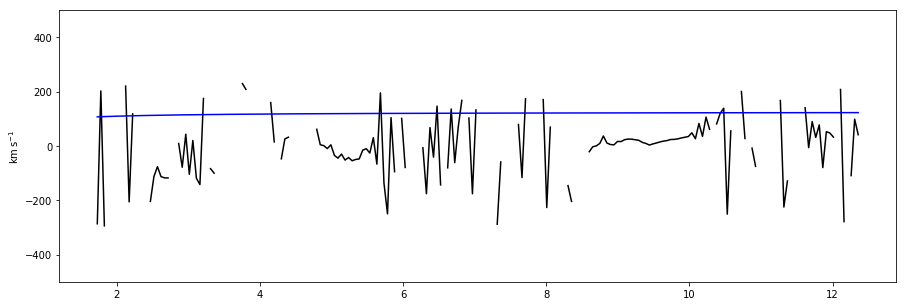

In [65]:
#tries with a fixed core (but that core isnt right, or even attempted to be)

#eriks model eqt 5

@custom_model #very necessary line
def eriksmodel(r, alpha=.001, beta=.001, sigma=250, omega=.4):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
m_init = eriksmodel()
fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.plot(distances_sections_target, y_axis_Gvelocity, color='k')
#plt.plot(distances_sections_target,y_axis_Gvelocity_crazyerrmasked,color='r')
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(-2000,2000)
plt.ylim(-500,500) #zooms to see data good, if fit is good
#plt.ylim(-20000,20000) #to see whole effect of param playing on fit line

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(distances_sections_target, y_axis_Gvelocity, color='k')
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.ylim(-200,200)